In [1]:
from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
sys.path.append('/rds/user/co-ripa1/hpc-work/scripts/meld_classifier_GDL')
from meld_graph.data_preprocessing import Preprocess

Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1
Setting FS_SUBJECTS_PATH to 


In [2]:
features=[
'.on_lh.curv.mgh',
 '.on_lh.gm_FLAIR_0.25.mgh',
 '.on_lh.gm_FLAIR_0.5.mgh',
 '.on_lh.gm_FLAIR_0.75.mgh',
 '.on_lh.gm_FLAIR_0.mgh',
 '.on_lh.pial.K_filtered.sm20.mgh',
 '.on_lh.sulc.mgh',
 '.on_lh.thickness.mgh',
 '.on_lh.w-g.pct.mgh',
 '.on_lh.wm_FLAIR_0.5.mgh',
 '.on_lh.wm_FLAIR_1.mgh'
]

In [3]:
## test function to compute scaling parameters

site_codes=['H2', 'H3','H4','H5','H6','H7','H9','H10','H11','H12','H14','H15','H16','H17','H18','H19',
                  'H21','H23','H24','H26']
cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix.hdf5', dataset='MELD_dataset_V6.csv')

#create object 
scale = Preprocess(cohort, 
                   site_codes=site_codes, 
                   write_output_file='scaling_params_GDL.json', 
                   data_dir=BASE_PATH)


for feature in features:
    scale.compute_scaling_parameters(feature)


In [48]:
## test function to compute scale individual data

subject = 'MELD_H6_3T_FCD_0011'

file_name='scaling_params_GDL.json'
file = os.path.join(BASE_PATH, file_name)
with open(file, "r") as f:
    params_norm = json.loads(f.read())
            
subj = MeldSubject(subject, cohort=cohort)

#load data & lesion
vals_array_lh, lesion_lh = subj.load_feature_lesion_data(features, hemi='lh')
vals_array_rh, lesion_rh = subj.load_feature_lesion_data(features, hemi='rh')
vals_array = np.array(np.hstack([vals_array_lh[cohort.cortex_mask].T, vals_array_rh[cohort.cortex_mask].T]))
lesion_array = np.array(np.hstack([lesion_lh[cohort.cortex_mask].T, lesion_rh[cohort.cortex_mask].T]))


#scale data
scaled_data = scale.scale_data(vals_array, features, file_name)

#check scaling
import matplotlib.pyplot as plt
  
fig,axes = plt.subplots(11,2,figsize=(8,20))
for f, feature in enumerate(features):
    #clip raw data to compare
    min_val = float(params_norm[feature]["min"])
    max_val = float(params_norm[feature]["max"])
    vals_array[f][vals_array[f]<min_val]= min_val
    vals_array[f][vals_array[f]>max_val]= max_val
    #plot raw and scaled
    axes[f,0].hist(vals_array[f] )
    axes[f,1].hist(scaled_data[f])
    
plt.tight_layout()

0.4385762
0.043857634


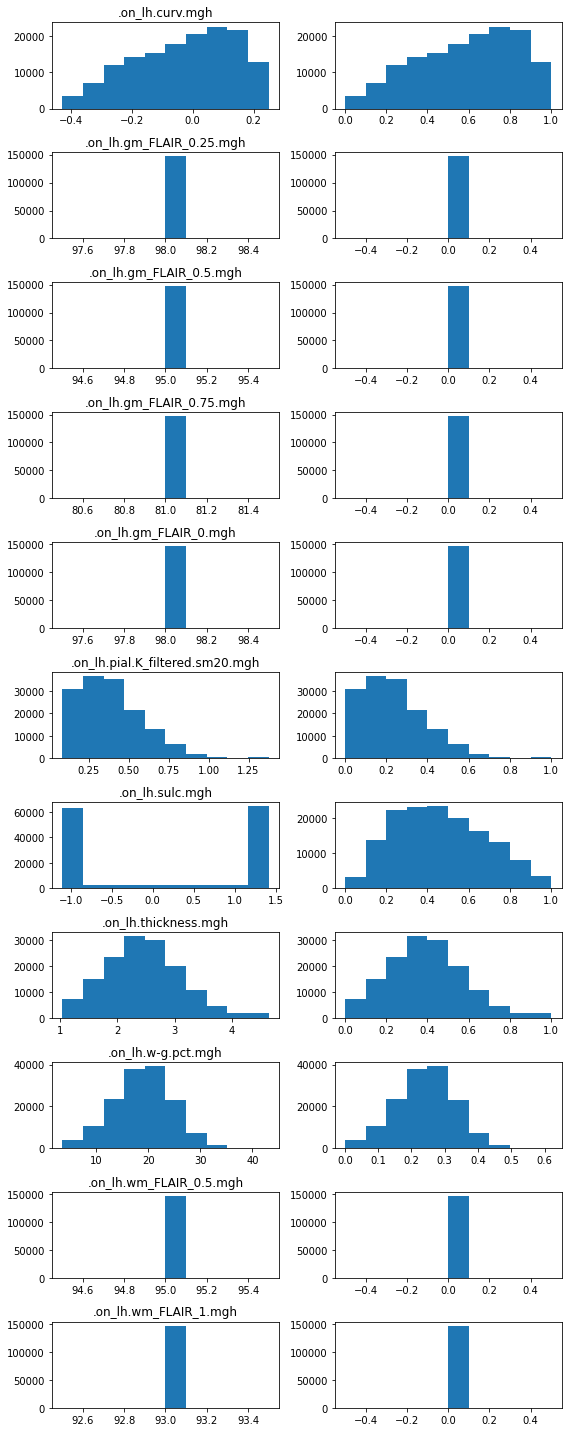

In [3]:
## test function to preprocess single subject

site_codes=['H2', 'H3','H4','H5','H6','H7','H9','H10','H11','H12','H14','H15','H16','H17','H18','H19',
                  'H21','H23','H24','H26']
cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix.hdf5', dataset='MELD_dataset_V6.csv')

#create object 
preproc = Preprocess(cohort, 
                   site_codes=site_codes, 
                   write_output_file='None', 
                   data_dir=BASE_PATH)

params={'scaling':'scaling_params_GDL.json'}

# get data preprocessed one subject
subject = 'MELD_H6_3T_FCD_0006'

features_lh, features_rh, lesion_lh, lesion_rh = preproc.get_data_preprocessed(subject, features, params)

#get raw data to compare 
file_name='scaling_params_GDL.json'
file = os.path.join(BASE_PATH, file_name)
with open(file, "r") as f:
    params_norm = json.loads(f.read())
    
    
subj = MeldSubject(subject, cohort=cohort)

#load data & lesion
vals_array_lh, lesion_lh = subj.load_feature_lesion_data(features, hemi='lh')
vals_array_rh, lesion_rh = subj.load_feature_lesion_data(features, hemi='rh')

#check scaling  
fig,axes = plt.subplots(11,2,figsize=(8,20))
for f, feature in enumerate(features):
    #clip data
    min_val = float(params_norm[feature]["min"])
    max_val = float(params_norm[feature]["max"])
    vals_array_lh.T[f, cohort.cortex_mask] = np.clip(vals_array_lh.T[f, cohort.cortex_mask], min_val, max_val)
    axes[f,0].hist(vals_array_lh.T[f, cohort.cortex_mask] )
    axes[f,1].hist(features_lh[f, cohort.cortex_mask])
    axes[f,0].set_title(feature)
    
plt.tight_layout()